In [6]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from skimpy import skim, clean_columns
import scipy.stats as stats
import os
import random
import os
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore") #sanest python user

%matplotlib inline

# Get familiar with the PTB dataset by examining different example time series and studying the distribution of labels (1 Pt). 

In [ ]:
# Use this comand to move form the current directory to the directory where you have the task1 fro project2
# I created as we did in project1 a folder called "data" with all the data inside of it

# Here the example: 

#os.chdir(r"C:\Users\gianf\Desktop\ETH\II_Semestre\ML4HC\ML4Healthcare\project2\task1")

In [19]:
path_train = r"data\ptbdb_train.csv"
path_test = r"data\ptbdb_test.csv"

ptbdb_train=pd.read_csv(path_train, header=None)

In [14]:
ptbdb_train.shape

(11641, 188)

In [20]:
ptbdb_train.iloc[:,187].unique()

array([1., 0.])

On page 12 of the Project presentation we get the information that the last column tells us whether a given patient has a myocardial infection or not. We can see below that it does indeed only consist of 0s and 1s.

In [21]:
ptbdb_train.iloc[:,187].value_counts()

187
1.0    8404
0.0    3237
Name: count, dtype: int64

Regarding the distribution of the labels, we definitely have a lot more sick people than healthy people in our training dataset. Out of 11641 patients in total, 8404 have a myocardial infarction and 3237 do not. Thus, we have more than double the amount of sick patients than healthy ones.

To take a look at the data we observe the first row of entries:

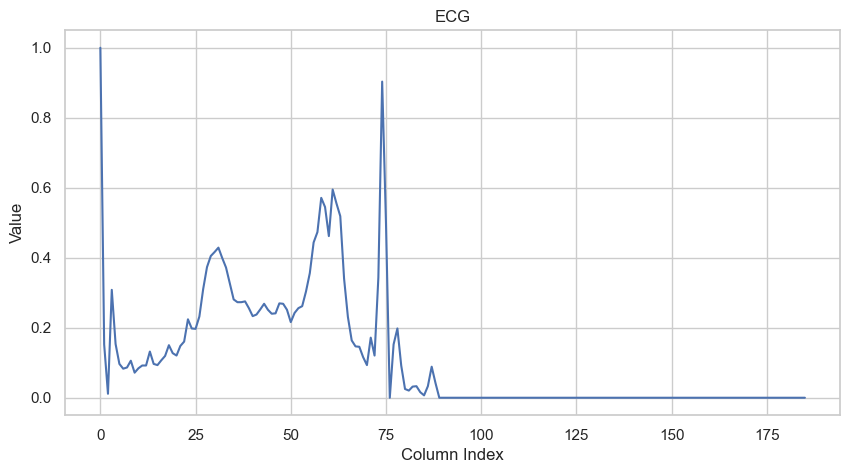

In [22]:
plt.figure(figsize=(10, 5)) 
plt.plot(ptbdb_train.iloc[1,0:186].index, ptbdb_train.iloc[1,0:186].values, marker=None, linestyle='-') 
plt.title('ECG')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

As also mentioned in the Project presentation, the last entries seem to be padded with 0 to get the desired dimension of 187 entries. This is undesirable in general, because it gives a wrong impression, however since we do not know what the process behind recording the ECG was, it might be interesting to know how many values had to get padded with 0. Thus, we will replace all the padded 0s at the end with NAs, but also create a new column which tells us how many 0s got replaced.

In [77]:
def count_padded_zeros(row):
    row_list = row.tolist()
    # We want to go from the right, so we reverse the list:
    reversed_list = row_list[::-1]
    count0s=0
    #Note: We put range(1, ...) so that the 1st, i.e. last column gets skipped, because in this column we have the health status of the patient
    for i in range(1,len(reversed_list)):
        if reversed_list[i] != 0:
            break
        count0s+=1
        
    # Reverse the list again before returning
    return count0s

count0s = ptbdb_train.apply(lambda row: pd.Series(count_padded_zeros(row)), axis=1)

In [78]:
def replace_padded_zeros(row):
    row_list = row.tolist()
    # We want to go from the right, so we reverse the list:
    reversed_list = row_list[::-1]
    count0s=0
    #Note: We put range(1, ...) so that the 1st, i.e. last column gets skipped, because in this column we have the health status of the patient
    for i in range(1,len(reversed_list)):
        if reversed_list[i] != 0:
            break
        reversed_list[i] = np.nan
        count0s+=1
        
    # Reverse the list again before returning
    return reversed_list[::-1]

# Apply the function to each row
data_train = ptbdb_train.apply(lambda row: pd.Series(replace_padded_zeros(row)), axis=1)
data_train.shape

(11641, 188)

Now we add the column which counted the number of padded 0s from before:

In [79]:
Last_col=data_train.shape[1]
Last_col
data_train.insert(Last_col-1, "NumPadded0s", count0s, False)
data_train.shape

(11641, 189)

We now plot the first few ECGs to get an idea of how they look:

In [118]:
random.seed(1)
random_healthy = data_train[data_train.iloc[:,-1] == 0].sample(n=3)
random_unhealthy = data_train[data_train.iloc[:,-1] == 1].sample(n=3)
random_patients = pd.concat([random_healthy, random_unhealthy])

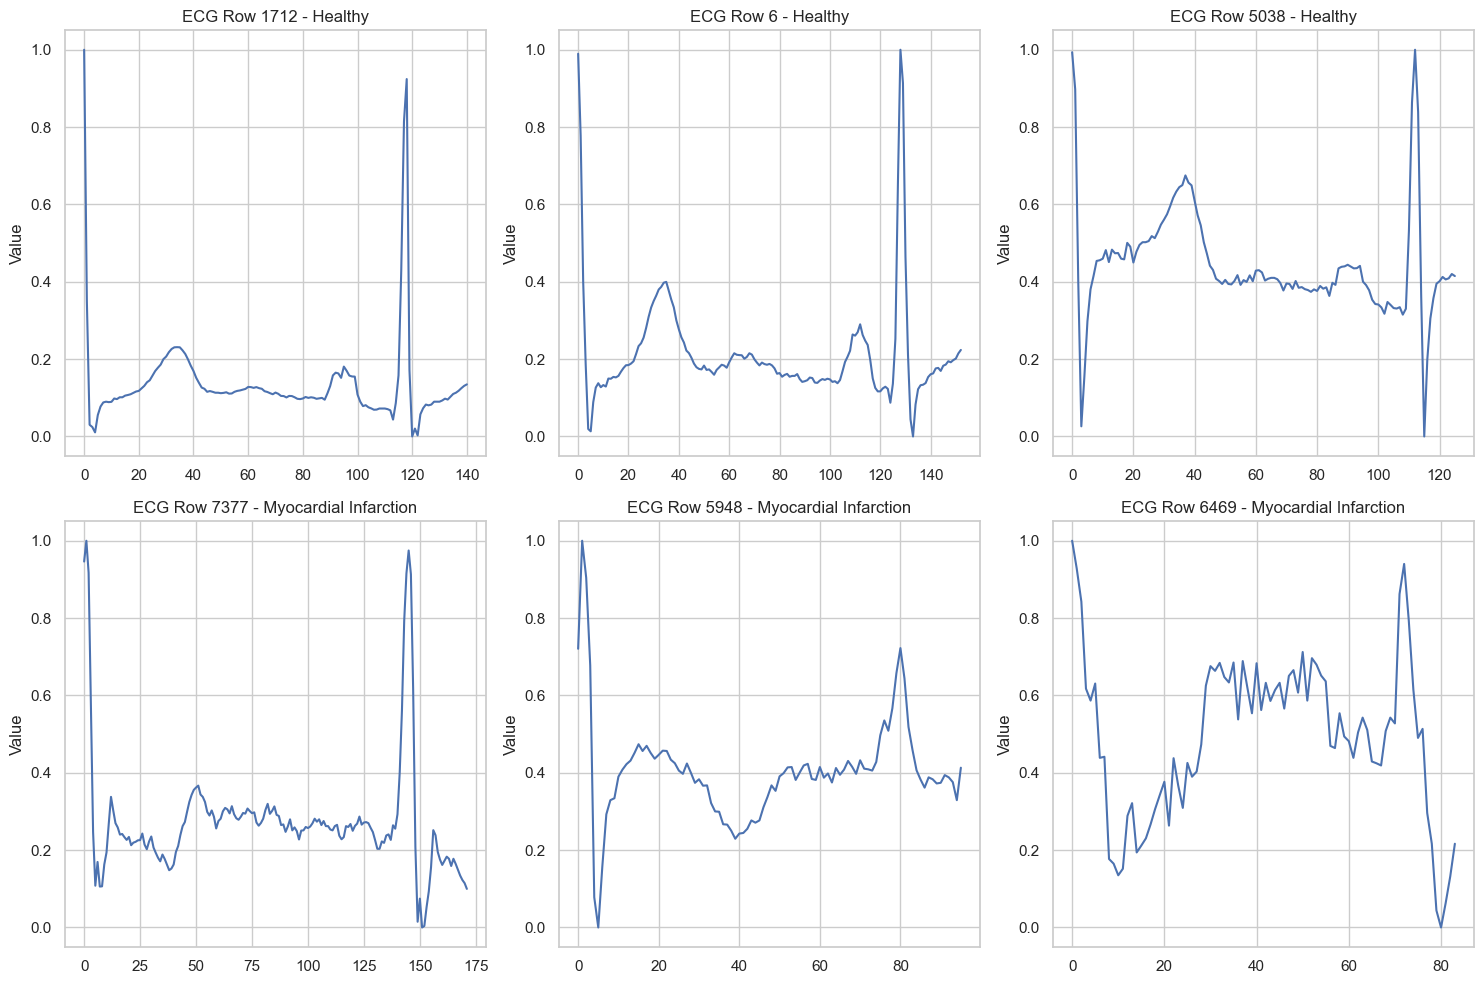

In [119]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axes = axes.flatten()

#9 plots
for i in range(6):
    #Only plot the ECG until column 186
    row_data = random_patients.iloc[i, 0:186]
    axes[i].plot(row_data.index, row_data.values, linestyle='-')
    Status = 'Healthy' if random_patients.iloc[i,-1] == 0 else "Myocardial Infarction"
    index=random_patients.iloc[:, 0:186].index.to_list()[i]
    axes[i].set_title(f'ECG Row {index} - {Status}')
    #axes[i].set_xlabel(Status)
    axes[i].set_ylabel('Value')
    axes[i].grid(True)

# Prevent overlapping
plt.tight_layout()
plt.show()

When looking at the randomised rows, we can't discern any early patterns yet that might indicate whether a patient is healthy or not.

# Choose one or more appropriate metric(s) for the classification task (1 Pt).

Since we are working in a context where False Negatives are a lot more severe than False Positives, the Recall = $\frac{TP}{TP+FN}$ is our most important metric.
We saw before that there is an inbalance in the distribution of the labels. However, since the dataset is not very unbalanced - it is about a 2/3-1/3 split - the accuracy is also still a worthy metric to consider.
By also including the the Precision, we can also plot the Precision-Recall Curve (ROC) and calculate the corresponding AUC.
Summing up, the three metrics we are considering are Recall, Accuracy and Precision.